# Gradient based iterative inverse design: Neural adjoint

Now we want to use the forward model as differentiable surrogate to perform a gradient based optimization on a large set of test-solutions. In this way we hope that some initial guesses are close enough to the global optimum for the gradient optimization to converge and not get stuck in local extrema.


## Import modules

In [1]:
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import helper

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-06-30 12:11:26.789346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 12:11:27.375435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-30 12:11:28.386528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 12:11:28.404576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## load the training data

In [2]:
data_path = 'datasets/dataset1_random.h5'

# load data and scalers
x_train, x_test, y_train, y_test = helper.load_reflection_spectra_data(
    data_path)
wavelengths = np.linspace(500, 1500, 64)
scaler_mat, scaler_thick = pickle.load(
    open('{}_scalers.pkl'.format(os.path.splitext(data_path)[0]), 'rb'))

## load pre-trained forward model and freeze weights

The forward model is pre-trained, we do not want it to be modified (further trained) in the inverse net training. If the forward model was subject to further training, the inputs would loose their meaning as design parameters.
We therefore need to set the forward model as not trainable. 

*Note*: If a full model is set to `trainable = False`, the model needs to be compiled, for it to have an effect. Setting the model to `trainable = False` after compilation, this does not have any effect. To avoid recompilation, every single layer can be set to `trainable=False` in a loop through the model layers, which works also on compiled models without re-compilation.

In [3]:
model_path = 'models/fwd_model_resnet.h5'

# load pretrained forward model
fwd_model = keras.models.load_model(model_path)

2023-06-30 12:11:29.379690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 12:11:29.379888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 12:11:29.380006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Select a test-spectrum as inverse design target

For simplicity we take a test-sample spectrum

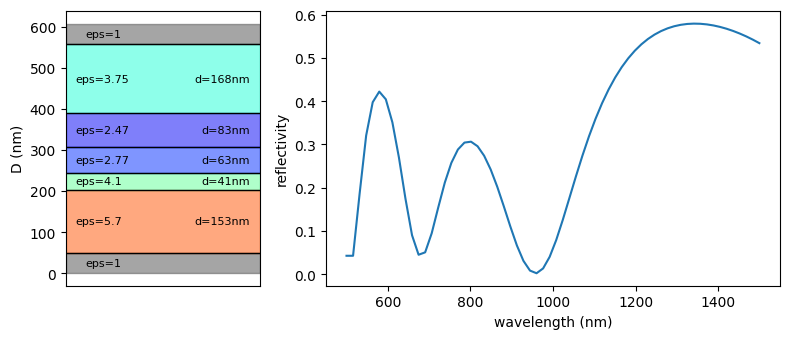

In [4]:
i_test = 6
target = y_test[i_test]

plt.figure(figsize=(8, 3.5))

plt.subplot(131)
helper.plot_stack_from_raw_predict(x_test[i_test], scaler_mat, scaler_thick)

plt.subplot2grid((1, 3), (0, 1), colspan=2)
plt.plot(wavelengths, y_test[i_test])
plt.xlabel("wavelength (nm)")
plt.ylabel("reflectivity")

plt.tight_layout()
plt.show()

## Implement the neural adjoint loop

We define first the losses for the neural adjoint gradient based optimization. The main loss is the MSE of the difference between predicted reflectivity and target reflectivity. A second loss loosely constrains the design parameters to values between $-1.5$ and $+1.5$.

We then define the gradient calculation as compiled tensorflow functional (decorator `@tf.function`). This decorator is optional but speeds up evaluation by typically more than a factor of 2. In this function we evaluate the forwad model with the test designs and calulate the losses, for which we calculate the gradients w.r.t. the designs. We return these gradients, they are going to be used in the NA-loop with a keras optimizer, to update the geometry parameters.

Finally, we define the main NA loop in a NA-function. It contains a random initial guess generation and a loop over calculation of the loss gradients and design-updates. We also add some status printing.

In [5]:
# --- losses
def L2_designtarget(y_target, y_pred):
    # design loss: Reproduce target spectrum
    return keras.backend.mean(keras.backend.square(y_pred - y_target), axis=(1, 2))


def loss_param_constraint(x_design):
    # parameter constraint loss: penalize design parameters outside normalization range
    return keras.backend.mean(tf.keras.activations.relu((keras.backend.abs(x_design) - 1.5), alpha=0.0))


# --- regularized neural adjoint gradient evaluation
@tf.function  # compile function to tensorflow static graph --> ~2x faster
def train_step_neural_adjoint(input_geo, input_target, weight_constraint_geo, fwd_model):
    with tf.GradientTape() as tape:
        tape.watch(input_geo)
        # predict the scattering by passing latent through generator and fwd model
        pred = fwd_model(input_geo)

        # calc fitness of physics response
        loss1 = L2_designtarget(input_target, pred)
        loss2 = loss_param_constraint(input_geo)
        fitness = loss1 + loss2*weight_constraint_geo

    # latent-value-wise gradients with respect to the loss, optimize `input_z`
    gradients = tape.gradient(fitness, input_geo)
    grad_rescaled = 1E6 * gradients / len(input_target)
    return grad_rescaled  # return the gradients


# helper: status text
def status_text_NA(inv_design_geo, input_target, weight_constraint_geo, fwd_model):
    y_pred = fwd_model(inv_design_geo)
    L2_loss_target = L2_designtarget(input_target, y_pred)
    loss_constr = loss_param_constraint(inv_design_geo)
    loss_total = L2_loss_target + loss_constr*weight_constraint_geo

    status_text = "best: T-loss {:.2e}, constraint_loss {:.2e}, total {:.2e}".format(
        np.min(L2_loss_target), np.min(loss_constr), np.min(loss_total))

    return status_text


# helper: sorting results by loss
def sort_NA_results(inv_design_geo, input_target, weight_constraint_geo, fwd_model):
    # --- end of loop: sort results as function of loss
    y_pred = fwd_model(inv_design_geo)
    L2_loss_target = L2_designtarget(input_target, y_pred)
    loss_constr = loss_param_constraint(inv_design_geo)
    loss_total = L2_loss_target + loss_constr*weight_constraint_geo

    idx_sort = np.argsort(L2_loss_target, axis=0)
    inv_design_sorted = inv_design_geo.numpy()[idx_sort]
    del inv_design_geo

    return loss_total, inv_design_sorted


#  neural adjoint main function
def do_NA(init_geo, design_target, fwd_model, optimizer, N_epoch, weight_constraint_geo):
    # --- initialize variables
    N_population = len(init_geo)
    init_geo = tf.convert_to_tensor(init_geo, dtype=tf.float32)
    # tf variable --> optimizer can modify
    inv_design_geo = tf.Variable(init_geo)

    # copy target design for each geometry
    target_spec_Ntimes = np.tile(design_target, (N_population, 1, 1))
    target_spec_Ntimes = tf.convert_to_tensor(
        target_spec_Ntimes, dtype=tf.float32)

    # --- the actual optimization loop
    # input_geo = inv_design_geo
    input_target = target_spec_Ntimes
    pbar = tqdm(range(N_epoch))
    for i in pbar:
        # calc. gradients; optimizer to adjust the designs
        grad_rescaled = train_step_neural_adjoint(
            inv_design_geo, input_target, weight_constraint_geo, fwd_model)
        optimizer.apply_gradients(zip([grad_rescaled], [inv_design_geo]))

        # status printing
        if i % 5 == 0:
            status_text = status_text_NA(
                inv_design_geo, input_target, weight_constraint_geo, fwd_model)
            pbar.set_description(status_text)

    loss_total, inv_design_sorted = sort_NA_results(
        inv_design_geo, input_target, weight_constraint_geo, fwd_model)

    return loss_total, inv_design_sorted

## Demo: NA without geometry constraint

<span style="color:red">**caution**: This demonstrates a failing configuration</span>

If no geometry constraint is used, the network tends to converge to failed solutions in the extrapolation regime of the forward network: the surrogate model predicts a matching spectral response, but the prediction is actually a bad extrapolation. Note that the parameter constraint loss is disabled by setting its weight `weight_constraint_geo = 0.0` (instead of `=0.1` in the following example).

  0%|          | 0/150 [00:00<?, ?it/s]2023-06-30 12:19:03.707145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-30 12:19:05.210196: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55c132578e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-30 12:19:05.210235: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-06-30 12:19:05.213714: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-30 12:19:05.334917: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-06-30 12:19:05.369969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix 

pymoosh: calculating R for 6 samples...


6it [00:00, 61.96it/s]

The forward network predictions indicate almost perfect designs.


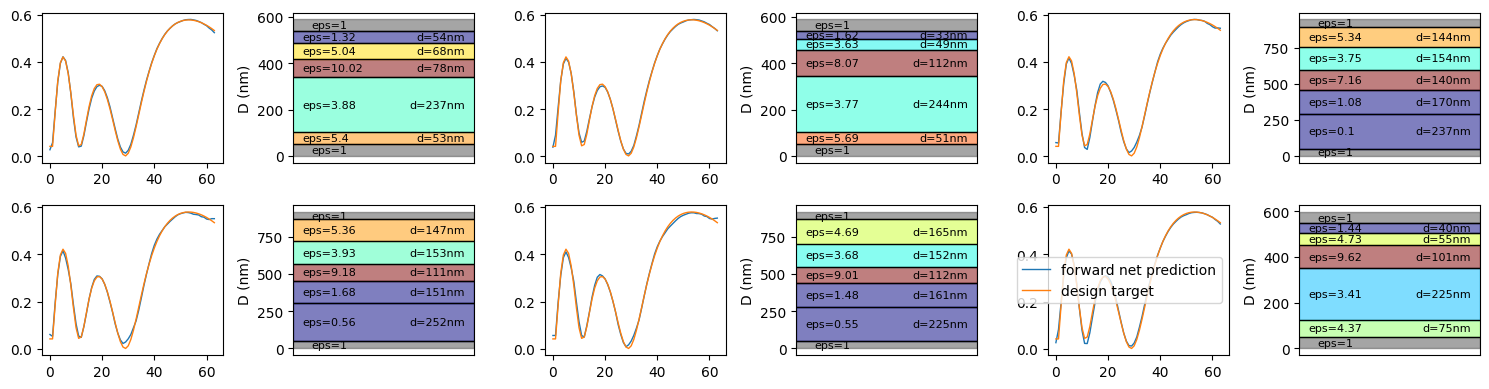

Now we calculate the reflectivities with pymoosh. --> Actually the forward net predictions are incorrect!


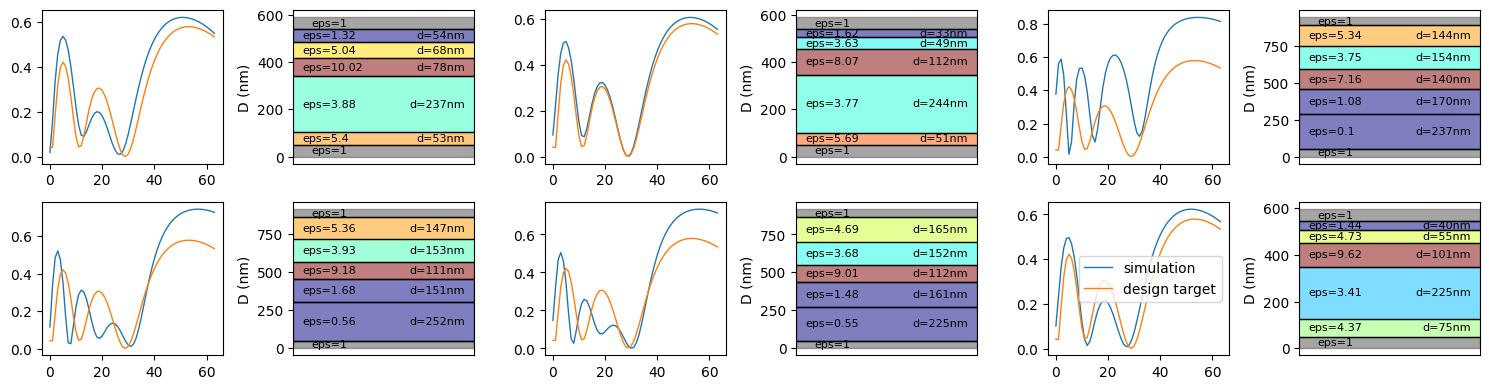

In [7]:
# config NA run
N_epoch = 150
N_population = 100
weight_constraint_geo = 0.0
optimizer = keras.optimizers.Adam(learning_rate=0.5)    # the optimizer algo.

# generate random init population and run NA, deliberately start with a non-standardized distribution
init_geo = np.random.normal(
    5, 2, size=[N_population, x_train.shape[1], x_train.shape[2]])

# run the NA
loss_tot, inv_design_sorted = do_NA(
    init_geo, target, optimizer=optimizer, fwd_model=fwd_model,
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# predict designs and their R-spectra (via forward model)
designs_predict = inv_design_sorted[:6]
y_predict = fwd_model.predict(designs_predict, verbose=0)

# scaler inverse transform: normalized datarange --> physical datarange
mat_physical = scaler_mat.inverse_transform(designs_predict[..., 0])
thick_physical = scaler_thick.inverse_transform(designs_predict[..., 1])

# pymoosh calculation of all designs
y_recalc = helper.batch_calc_R(thick_physical, mat_physical, wavelengths)

# forward network prediction - plot the six best samples
print("The forward network predictions indicate almost perfect designs.")
helper.plot_benchmark_R_samples(y_predict, np.tile(target, (len(y_recalc), 1, 1)),
                                random_order=False, plot_design=True,
                                y_designs=designs_predict,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['forward net prediction', 'design target'])

# pymoosh simulation of the same designs - plot the six best samples
print("Now we calculate the reflectivities with pymoosh. --> Actually the forward net predictions are incorrect!")
helper.plot_benchmark_R_samples(y_recalc, np.tile(target, (len(y_recalc), 1, 1)),
                                random_order=False, plot_design=True,
                                y_designs=designs_predict,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['simulation', 'design target'])


## Run NA with geometry constraint

Optimization tends to push the forward network to the extrapolation regime, where steep minima of the target function are found, but the error of these extrapolated predictions are very high. this can be avoided using constraints on the target geometry.

Here we run NA with loosely constrained parameters. Even though we deliberately use a starting distribution of random geometries outside of the input data range, thanks to the additional gradients of the constraint function, the optimization converges to valid solutions inside the foward model's interpolation regime.

best: T-loss 7.16e-06, constraint_loss 5.30e-03, total 5.37e-04: 100%|██████████| 150/150 [00:03<00:00, 37.55it/s]


pymoosh: calculating R for 6 samples...


6it [00:00, 103.06it/s]


With geometry constraint loss, the NA finds good solutions that can be pymoosh-verified:


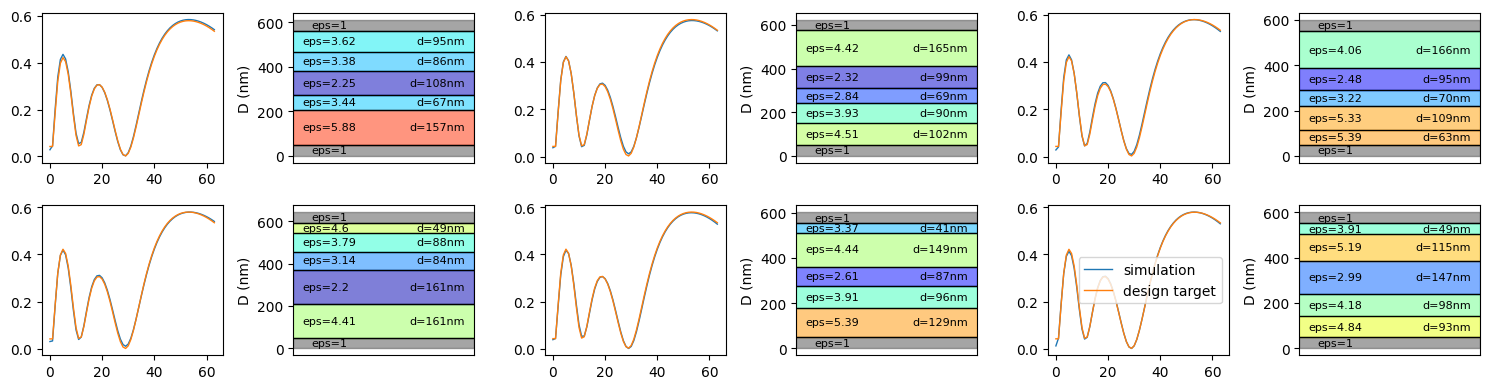

In [9]:
# config NA run
N_epoch = 150
N_population = 100
weight_constraint_geo = 0.1

# generate random init population and run NA, deliberately start with a non-standardized distribution
init_geo = np.random.normal(
    5, 2, size=[N_population, x_train.shape[1], x_train.shape[2]])

optimizer = keras.optimizers.Adam(learning_rate=0.5)    # the optimizer algo.

loss_tot, inv_design_sorted = do_NA(
    init_geo, target, optimizer=optimizer, fwd_model=fwd_model, 
    N_epoch=N_epoch, weight_constraint_geo=weight_constraint_geo)


# --- Evaluate (best solutions)
# predict designs and their R-spectra (via forward model)
designs_predict = inv_design_sorted[:6]
y_predict = fwd_model.predict(designs_predict, verbose=0)

# scaler inverse transform: normalized datarange --> physical datarange
mat_physical = scaler_mat.inverse_transform(designs_predict[..., 0])
thick_physical = scaler_thick.inverse_transform(designs_predict[..., 1])

# pymoosh calculation of all designs
y_recalc = helper.batch_calc_R(thick_physical, mat_physical, wavelengths)

# plot the six best samples
print("With geometry constraint loss, the NA finds good solutions that can be pymoosh-verified:")
helper.plot_benchmark_R_samples(y_recalc, np.tile(target, (len(y_recalc), 1, 1)),
                                random_order=False, plot_design=True,
                                y_designs=designs_predict,
                                scaler_mat=scaler_mat, scaler_thick=scaler_thick,
                                labels=['simulation', 'design target'])
